In [2]:
%autoreload 2 
%matplotlib ipympl

import numpy as np 
from pianoq.misc.mplt import mplot, mimshow
from pianoq.simulations.abstract_quantum_scaling.qwfs_simulation import QWFSSimulation
from pianoq.simulations.abstract_quantum_scaling.qwfs_result import QWFSResult
from pianoq.misc.mplc_writeup_imports import *

# We trust the optimization works well for relevant dimensions
We run the BFGS optimization algorithms on the different configurations, and it seems to be working well, so we beleive its results also in the context of SLM3. 

Here N_modes=256 

In [233]:
path = r"G:\My Drive\Projects\MPLC\results\simulations\2024_11_26_16_55_09_qwfs_long_with_analytic.npz"
res = QWFSResult(path)

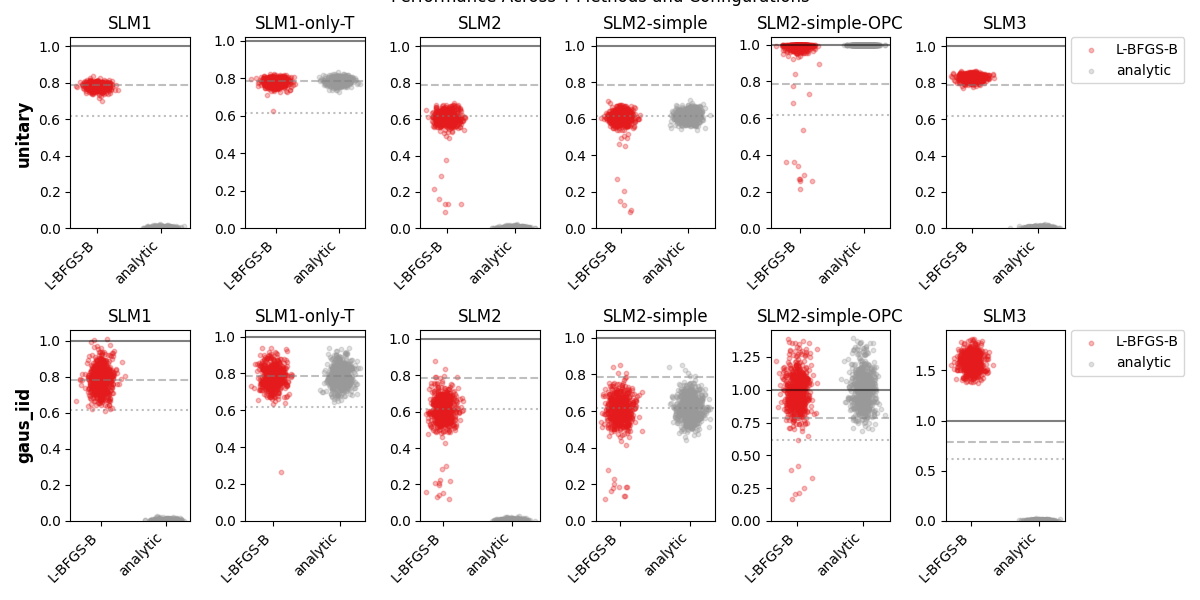

In [45]:
res.show_scatterplots()
plt.show(block=False)

In [259]:
res.print()
print(f'{res.N_modes=}')

---- SLM1 ----
-- unitary --
L-BFGS-B                  0.782+-0.02
analytic                  0.004+-0.00
-- gaus_iid --
L-BFGS-B                  0.786+-0.07
analytic                  0.004+-0.00

---- SLM1-only-T ----
-- unitary --
L-BFGS-B                  0.781+-0.02
analytic                  0.786+-0.02
-- gaus_iid --
L-BFGS-B                  0.782+-0.06
analytic                  0.787+-0.05

---- SLM2 ----
-- unitary --
L-BFGS-B                  0.604+-0.06
analytic                  0.004+-0.00
-- gaus_iid --
L-BFGS-B                  0.604+-0.09
analytic                  0.004+-0.00

---- SLM2-simple ----
-- unitary --
L-BFGS-B                  0.606+-0.05
analytic                  0.617+-0.03
-- gaus_iid --
L-BFGS-B                  0.604+-0.09
analytic                  0.618+-0.06

---- SLM2-simple-OPC ----
-- unitary --
L-BFGS-B                  0.977+-0.09
analytic                  1.000+-0.00
-- gaus_iid --
L-BFGS-B                  0.986+-0.15
analytic                  1.0

## conclusions: 
And it seems that the simulation is all more or less OK:
* For SLM1 with and without the FFT etc. we get the $\pi / 4$, both analytically and with the nonlinear search. 
* Same for SLM2 configuration, and for OPC. 
* In both cases the spread of results is wider with the Gaussian IID than with unitary matrices, but this is expected. 
* The nonlinear search sometimes fails. 
* SLM3 is indeed $0.83 > \pi / 4$ for unitary, and $\approx 1.5$ for Gaussian IID, which is interesting! 

So basically now I can forget about all the SLM1,SLM2,OPC, since they all work and make sense, and only need to think better about the SLM3 configuration, why we get more than $\pi/4$ and why we get $1.5$! These are two questions with probably pretty different answers. The 0.83 might be the result of some mathematical reasoning. The 1.5 has something to do with energy harvesting somehow. We should look at the intensity distribution at different places to see what's what. 

# understand the 1.5

## Total output intensity in crsytal and output planes 
It is interesting to look at the total intensity at the crystal plane and at the output plane. In the unitary case everything will always be 1 by definition, but what about the gaus_iid case? 

In [ ]:
path = r"G:\My Drive\Projects\MPLC\results\simulations\2024_11_26_16_55_09_qwfs_long_with_analytic.npz"
res = QWFSResult(path)

In [297]:
alg = 'L-BFGS-B'
config = 'SLM3'
T_method = 'gaus_iid'
# T_method = 'unitary'
try_nos = range(res.N_tries)

I_outs = []
I_middles = []
I_focuss = []
# for try_no in [2]:
for try_no in try_nos:
    alg_ind = np.where(res.algos == alg)[0]
    conf_ind = np.where(res.configs == config)[0]
    T_method_ind = np.where(res.T_methods == T_method)[0] 

    T_ind = res.N_T_methods * try_no + T_method_ind 
    T = res.Ts[T_ind].squeeze()
    slm_phases = res.best_phases[T_method_ind, conf_ind, try_no, alg_ind].squeeze()
    N = len(slm_phases)
    
    sim = QWFSSimulation(N=N)
    sim.T = T 
    sim.slm_phases = np.exp(1j*slm_phases)
    sim.config = config
    
    I_middle = np.abs(sim.T.transpose() @ (sim.slm_phases * sim.v_in))**2
    I_out = np.abs(sim.propagate())**2
    I_outs.append(I_out)
    I_middles.append(I_middle)
    I_focuss.append(res.results[T_method_ind, conf_ind, try_no, alg_ind].squeeze())
    
I_outs = np.array(I_outs)
I_middles = np.array(I_middles)
I_focuss = np.array(I_focuss)


Sample of output distribution in crystal and in output planes:

Text(0.5, 0.98, 'Intensity distribution')

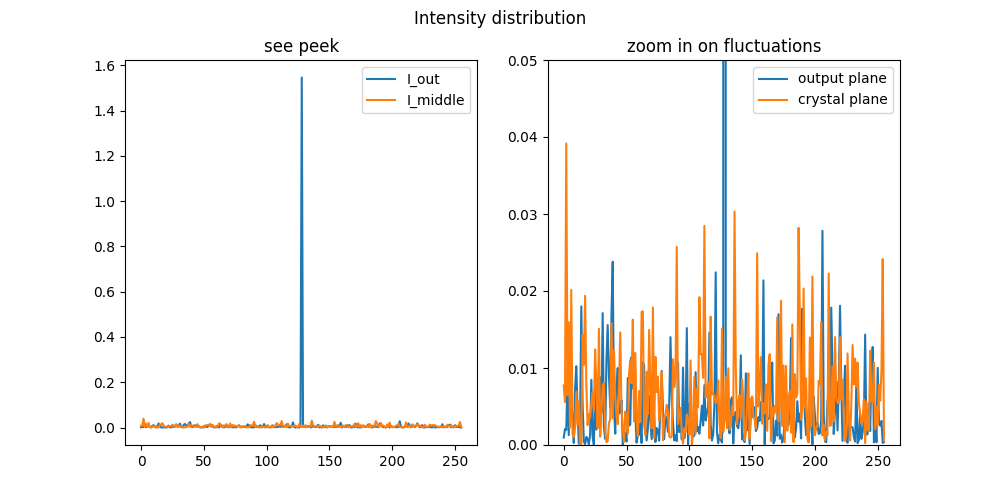

In [278]:
i = 10
I_out = I_outs[i]
I_middle = I_middles[i]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(I_out, label='I_out')
axes[0].plot(I_middle, label='I_middle')
# ax.set_ylim([0, 0.05])
axes[0].legend()
axes[1].plot(I_out, label='output plane')
axes[1].plot(I_middle, label='crystal plane')
axes[1].set_ylim([0, 0.05])
axes[1].legend()
axes[0].set_title('see peek')
axes[1].set_title('zoom in on fluctuations')
fig.suptitle('Intensity distribution')

And disribution of power at middle, at output, and of power at output / power at middle squared. 

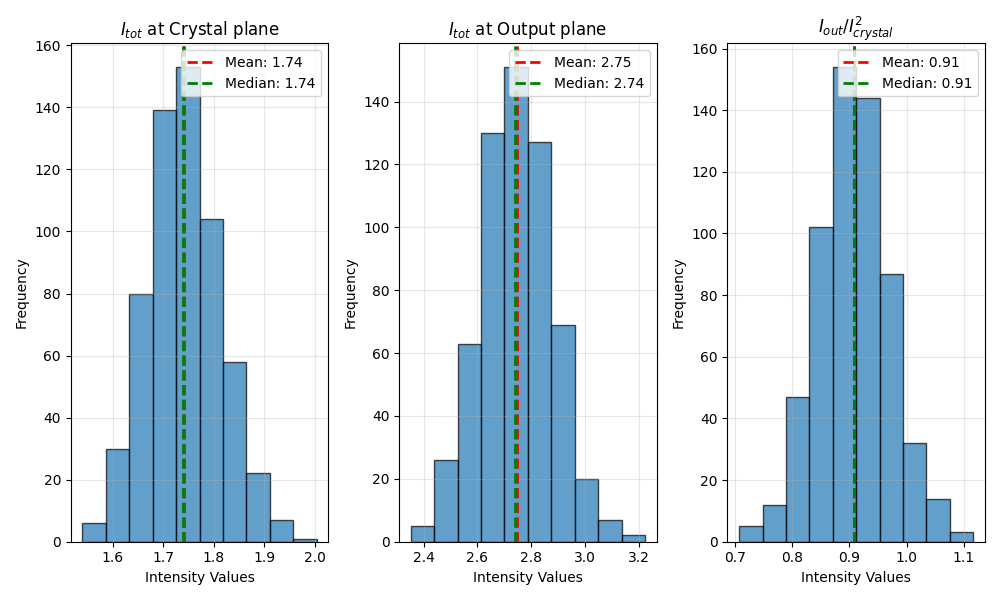

In [279]:
fig, axes = plt.subplots(1, 3, figsize=(10, 6))

for i, ax in enumerate(axes):
    if i == 0:
        Is = I_middles.sum(axis=1)
        title = '$I_{tot}$ at Crystal plane'
    elif i == 1:
        title = '$I_{tot}$ at Output plane'
        Is = I_outs.sum(axis=1)
    elif i == 2:
        title = r'$I_{out}/I_{crystal}^2$'
        Is = I_outs.sum(axis=1) / I_middles.sum(axis=1)**2
    # Create the histogram
    ax.hist(Is, bins=10, edgecolor='black', alpha=0.7)
    ax.set_title(title)
    ax.set_xlabel('Intensity Values')
    ax.set_ylabel('Frequency')
    
    # Add statistical lines
    ax.axvline(np.mean(Is), color='red', linestyle='dashed', linewidth=2, 
               label=f'Mean: {np.mean(Is):.2f}')
    ax.axvline(np.median(Is), color='green', linestyle='dashed', linewidth=2, 
               label=f'Median: {np.median(Is):.2f}')
    
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Adjust layout and display
    plt.tight_layout()

Interestingly, the total intensity at the crystal plane with the optimized phase is also already ~1.7! And then it grows larger to 2.75. So these phases somehow grows the intensity in both trips, which is a little bit surprising. It also seems that the "gain" of the first and second path are roughly the same, with the second pass having slightly less gain (0.9x).

But we should ask - how hard is it to get such high gain? For random phases - how much gain should I expect? In this graph we play with random phases and look at the output total intensity and see that we are several standard deviations away. (2.7 compared to ~1+-0.1) 

In [265]:
sim = QWFSSimulation(N=256)
sim.config = 'SLM3'
sim.T_method = 'gaus_iid'
sim.reset_T()
Is = []
for i in range(10000):
    random_phases = np.random.uniform(0, 2*np.pi, sim.N)
    sim.slm_phases = np.exp(1j*random_phases)
    # sim.slm_phases = np.exp(1j*slm_phases)
    v_out = sim.propagate()
    I_out = np.abs(v_out)**2
    Is.append(I_out.sum())

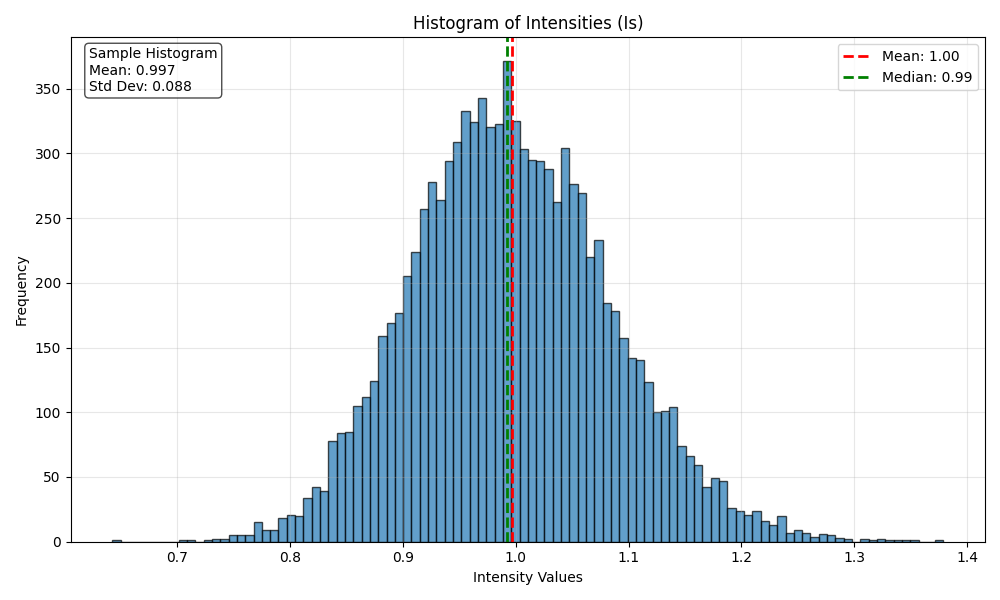

In [269]:
fig, ax = plt.subplots(figsize=(10, 6))

# Create the histogram
ax.hist(Is, bins=100, edgecolor='black', alpha=0.7)
ax.set_title('Histogram of Intensities (Is)')
ax.set_xlabel('Intensity Values')
ax.set_ylabel('Frequency')

# Add statistical lines
ax.axvline(np.mean(Is), color='red', linestyle='dashed', linewidth=2, 
           label=f'Mean: {np.mean(Is):.2f}')
ax.axvline(np.median(Is), color='green', linestyle='dashed', linewidth=2, 
           label=f'Median: {np.median(Is):.2f}')

ax.text(0.02, 0.98, 'Sample Histogram\nMean: {:.3f}\nStd Dev: {:.3f}'.format(np.mean(Is), np.std(Is)), 
         transform=ax.transAxes,  # Use axes coordinates
         verticalalignment='top',  # Align to the top
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

ax.legend()
ax.grid(True, alpha=0.3)

# Adjust layout and display
plt.tight_layout()

Another way to look at this is to look at the norm of rows and columns of the different Ts, which we see are also ~1.25. 


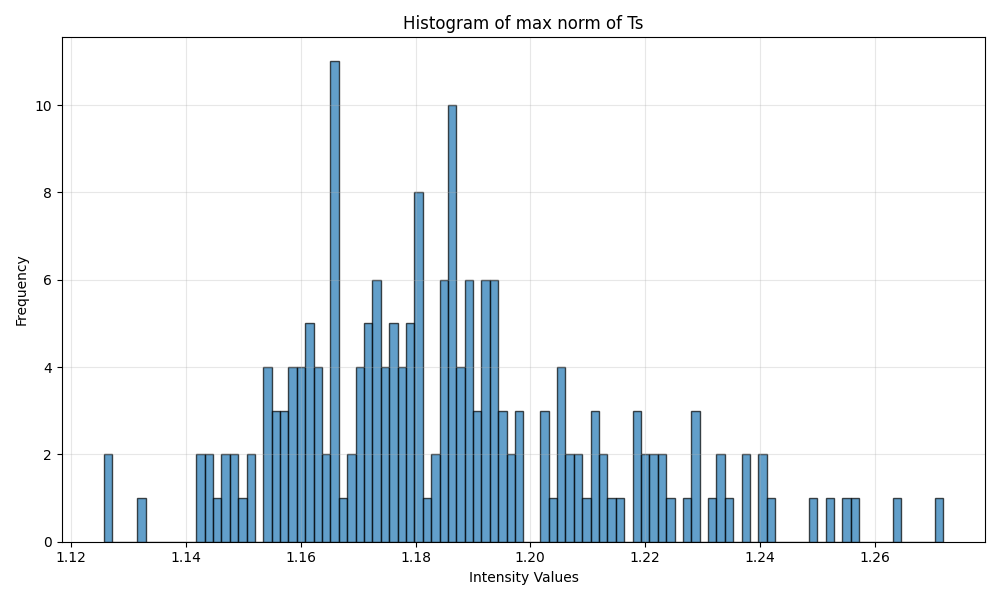

In [273]:
sim = QWFSSimulation(N=256)
sim.config = 'SLM3'
sim.T_method = 'gaus_iid'
max_Is = []
for i in range(100):
    sim.reset_T()
    max_I = (np.abs(sim.T)**2).sum(axis=0).max()
    max_Is.append(max_I)
    max_I = (np.abs(sim.T)**2).sum(axis=1).max()
    max_Is.append(max_I)
max_Is = np.array(max_Is)

fig, ax = plt.subplots(figsize=(10, 6))

# Create the histogram
ax.hist(max_Is, bins=100, edgecolor='black', alpha=0.7)
ax.set_title('Histogram of max norm of Ts')
ax.set_xlabel('Intensity Values')
ax.set_ylabel('Frequency')
ax.grid(True, alpha=0.3)

# Adjust layout and display
plt.tight_layout()


So we understand that we really somehow gain a significant amount of energy at the output. So how much is 1.5 comared to that? It is a great efficiency, but what is the contrast at the output? Let's plot it. (In the unitary configuration, or other configurationsit is not a relevant question, since the output power is 1... 

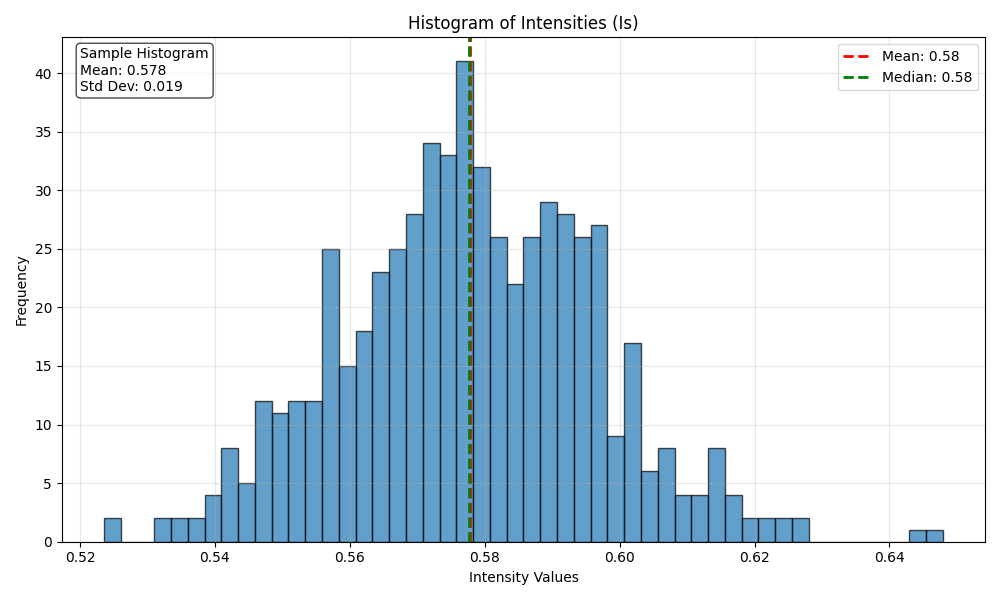

In [299]:
effics = I_focuss / I_outs.sum(axis=1)
fig, ax = plt.subplots(figsize=(10, 6))

# Create the histogram
ax.hist(effics, bins=50, edgecolor='black', alpha=0.7)
ax.set_title('Histogram of Intensities (Is)')
ax.set_xlabel('Intensity Values')
ax.set_ylabel('Frequency')

# Add statistical lines
ax.axvline(np.mean(effics), color='red', linestyle='dashed', linewidth=2, 
           label=f'Mean: {np.mean(effics):.2f}')
ax.axvline(np.median(effics), color='green', linestyle='dashed', linewidth=2, 
           label=f'Median: {np.median(effics):.2f}')

ax.text(0.02, 0.98, 'Sample Histogram\nMean: {:.3f}\nStd Dev: {:.3f}'.format(np.mean(effics), np.std(effics)), 
         transform=ax.transAxes,  # Use axes coordinates
         verticalalignment='top',  # Align to the top
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

ax.legend()
ax.grid(True, alpha=0.3)

# Adjust layout and display
plt.tight_layout()

And we get a distribution around $0.578\pm0.02$, which is worse than SLM2! But the question now remains - here we tried to maximze intensity and got 1.6, but with low contrast. What will happen if we try to maximize the contrast? 

TODO: Lets do this! 

## Other matrix types
I tried also a "cue" unitary, which is basically sampling a unitary with the Haar measure, and ti gives the exact same results as regular unitaries. Another thing to try is to use matrices with a bimodal distribution of eigen values $P(\tau)=\frac{1}{\tau\cdot\sqrt{1-\tau}}$ like real scatterimg medium, and see if we go through the open channels. 

TODD: try it 

In [280]:
pass

## Vary N_modes

I tried to see how these results vary with the dimension of the matrix. I also checked wether a different kind of random unitary creation will make a difference. As I expected - it didn't. But the dependence on N seems small, but existent. 

In [16]:
plt.close('all')
import re 
def get_Ns_ress(glob_regex):
    paths = glob.glob(glob_regex)
    ress = [QWFSResult(path) for path in paths]
    Ns = np.array([re.findall('.*N=(\d+)_.*', path)[0] for path in paths]).astype(float)
    Ns, ress = list(zip(*sorted(zip(Ns, ress), key=lambda pair: pair[0])))
    return np.array(Ns), np.array(ress)

def show_N_dependance(Ns, ress, which_config='SLM3', which_optimization='L-BFGS-B', full_std=False, ylim=None):
    T_methods = ress[0].T_methods
    fig, ax = plt.subplots()
    
    for T_method_no, T_method in enumerate(T_methods):
        effs = np.zeros_like(Ns)
        eff_stds = np.zeros_like(Ns)
        
        for i, N in enumerate(Ns):
            res = ress[i]
            config_no = list(res.configs).index(which_config)
            algo_no = list(res.algos).index(which_optimization)
            effs[i] = res.results[T_method_no, config_no].mean(axis=0)[algo_no]
            eff_stds[i] = res.results[T_method_no, config_no].std(axis=0)[algo_no]
        
        y_err = eff_stds
        if not full_std:
            y_err /= res.results.shape[2]
        ax.errorbar(Ns, effs, yerr=y_err, label=T_method, marker='o')
        # ax.errorbar(Ns, effs, yerr=eff_stds2, alpha=0.7, marker='o')
        
    if which_config in ['SLM1', 'SLM1-only-T']:
        Ns = np.linspace(Ns.min(), Ns.max(), 1000)
        theory = 1/Ns * (1 + (Ns-1)*np.pi/4)
        ax.plot(Ns, theory, linestyle='dashed', label='Theory SLM1')
    elif which_config in ['SLM2', 'SLM2-simple']:
        Ns = np.linspace(Ns.min(), Ns.max(), 1000)
        theory = 1/Ns * (1 + (Ns-1)*(np.pi/4)**2)
        ax.plot(Ns, theory, linestyle='dashed', label='Theory SLM2')
        
    if ylim:
        ax.set_ylim(ylim)
    
    ax.legend()    
    ax.set_xlabel('N_modes')
    ax.set_ylabel('Efficiency')
    ax.set_title(f'{which_optimization=}, {which_config=}')

In [17]:
# glob_regex = r'G:\My Drive\Projects\MPLC\results\simulations\2024_11_28_14*N=*.npz'
# glob_regex = r'G:\My Drive\Projects\MPLC\results\simulations\2024_11_28_15*N=*.npz'
glob_regex = r'G:\My Drive\Projects\MPLC\results\simulations\2024_1*N=*300_tries*weekend*.npz'
Ns, ress = get_Ns_ress(glob_regex)

In [224]:
full_std = False
which_optimization = 'L-BFGS-B'
# which_optimization = 'analytic'
which_config = 'SLM3'
# which_config = 'SLM1-only-T'
# which_config = 'SLM2-simple'
# which_config = 'SLM2-simple-OPC'
show_N_dependance(Ns, ress, which_config=which_config, which_optimization=which_optimization, full_std=False)

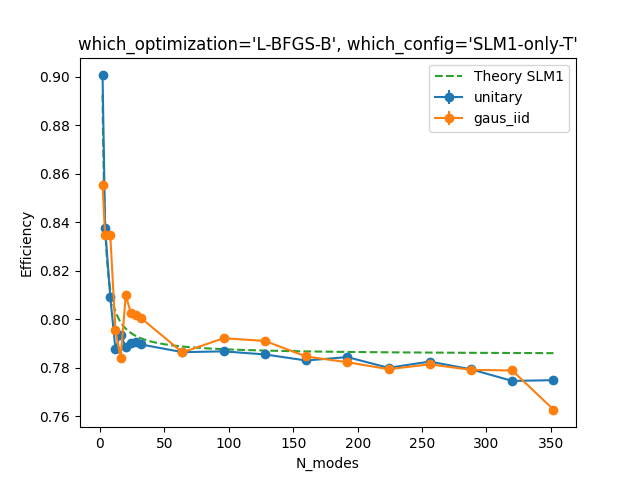

In [18]:
show_N_dependance(Ns, ress, which_config='SLM1-only-T', which_optimization='L-BFGS-B', full_std=False)

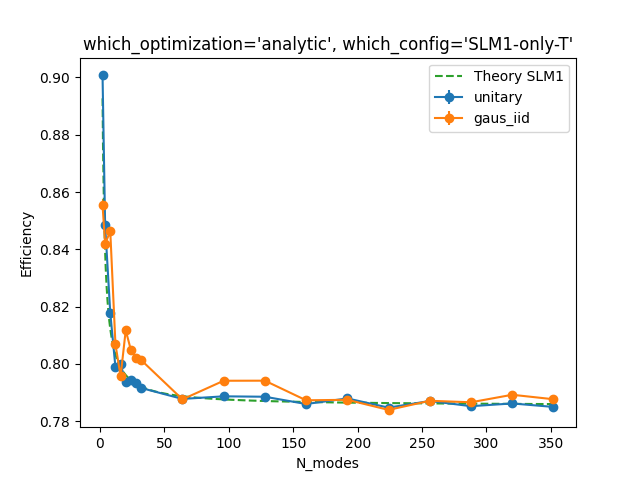

In [19]:
show_N_dependance(Ns, ress, which_config='SLM1-only-T', which_optimization='analytic', full_std=False)

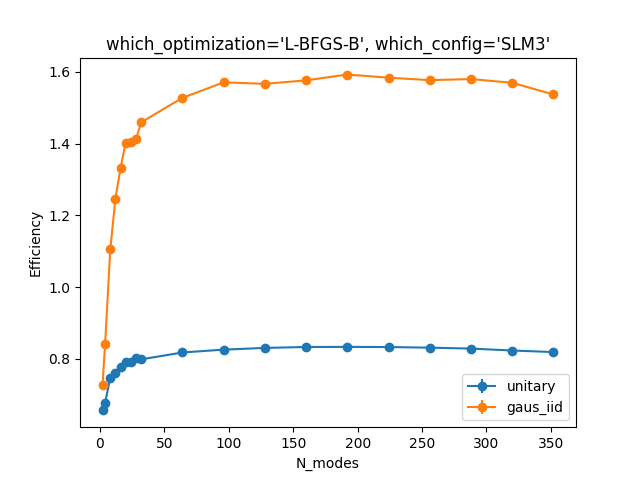

In [22]:
show_N_dependance(Ns, ress, which_config='SLM3', which_optimization='L-BFGS-B', full_std=False) # , ylim=[1.3 ,1.65])

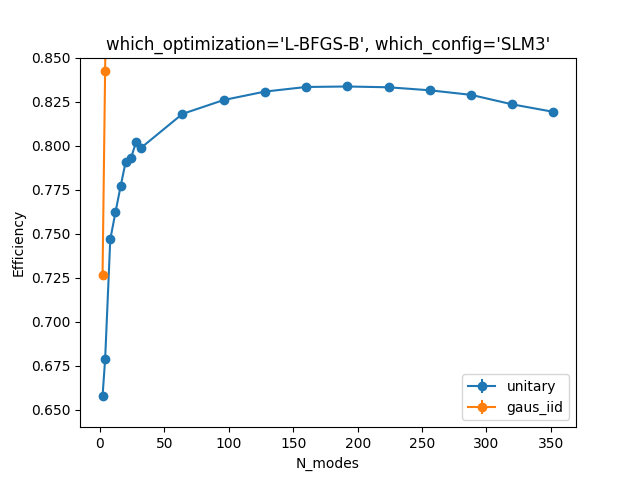

In [25]:
show_N_dependance(Ns, ress, which_config='SLM3', which_optimization='L-BFGS-B', full_std=False, ylim=[0.64 ,0.85])

And it seems that for SLM1 there is indeed a very slight N dependence due to $\eta=\frac{1}{N} + \frac{\pi}{4}\cdot\frac{N-1}{N}$, and it works pretty well. But for SLM3 we have a larger dependance, which is surprising. For large N values the down trend is probably due to the optimization not able to optimize the best. But it is not clear why it goes up with $N$. 

In [ ]:
full_std = False
which_optimization = 'L-BFGS-B'
# which_optimization = 'analytic'
which_config = 'SLM3'
# which_config = 'SLM1-only-T'
# which_config = 'SLM2-simple'
# which_config = 'SLM2-simple-OPC'
show_N_dependance(Ns, ress, which_config=which_config, which_optimization=which_optimization, full_std=False)


In [40]:
for res in ress:
    print(f'---{res.N_modes=}---')
    # res.show_scatterplots()
    # plt.show(block=False)
    res.print(only_slm3=True)

50

In [102]:
ress[0].Ts[3].real.std()

0.12201505813802402

## Varry sigma in gaus_iid
In hindsight this is trivial, since having a larger sigma in the gaus_iid will cause the average total intensity to be larger, so it changes drastically the total output power in SLM3, but similarly in SLM1 etc. 

In [230]:
plt.close('all')
import re 
def get_sigs_ress(glob_regex):
    paths = glob.glob(glob_regex)
    ress = [QWFSResult(path) for path in paths]
    sigs = np.array([re.findall('.*sig=(\d+(\.\d+)?)_.*', path)[0][0] for path in paths]).astype(float)
    return sigs, ress

def show_sig_dependance(sigs, ress, which_config='SLM3', which_optimization='L-BFGS-B', full_std=False):
    T_methods = ress[0].T_methods
    fig, ax = plt.subplots()
    
    for T_method_no, T_method in enumerate(T_methods):
        effs = np.zeros_like(sigs)
        eff_stds = np.zeros_like(sigs)
        
        for i, sig in enumerate(sigs):
            res = ress[i]
            config_no = list(res.configs).index(which_config)
            algo_no = list(res.algos).index(which_optimization)
            effs[i] = res.results[T_method_no, config_no].mean(axis=0)[algo_no]
            eff_stds[i] = res.results[T_method_no, config_no].std(axis=0)[algo_no]
        
        y_err = eff_stds
        if not full_std:
            y_err /= res.results.shape[2]
        ax.errorbar(sigs, effs, yerr=y_err, label=T_method, marker='o')
        # ax.errorbar(Ns, effs, yerr=eff_stds2, alpha=0.7, marker='o')
    ax.legend()    
    ax.set_xlabel('T_sig')
    ax.set_ylabel('Efficiency')

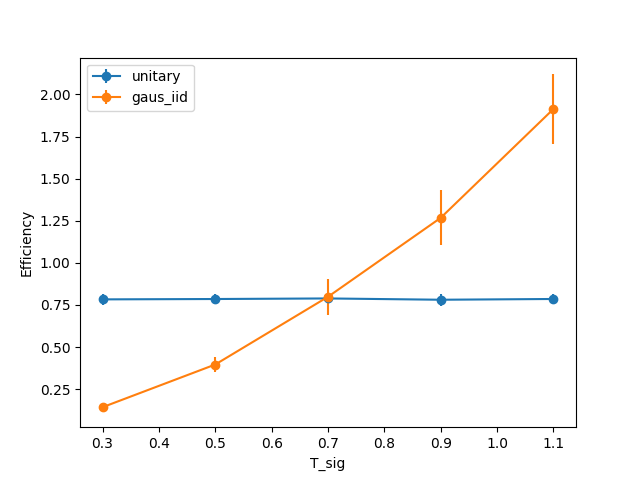

In [231]:
# glob_regex = r'G:\My Drive\Projects\MPLC\results\simulations\2024_11_28_16*sig=*.npz'
glob_regex = r'G:\My Drive\Projects\MPLC\results\simulations\2024_12_02*sig=*many_configs.npz'
sigs, ress = get_sigs_ress(glob_regex)
# show_sig_dependance(sigs, ress, which_config='SLM1-only-T', full_std=True)
# show_sig_dependance(sigs, ress, which_config='SLM2-simple', full_std=True)
# show_sig_dependance(sigs, ress, which_config='SLM2-simple-OPC', full_std=True)
show_sig_dependance(sigs, ress, which_config='SLM1-only-T', full_std=True)
# ress

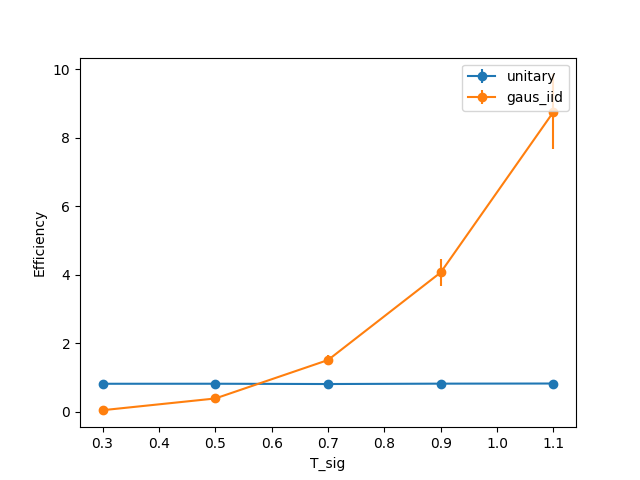

In [232]:
show_sig_dependance(sigs, ress, which_config='SLM3', full_std=True)

# Analytical understanding 

Well, we finally understood that if for instancewe want to look at the first fourier mode after the second hit of the SLM, so the fourier elements of F are simply $1/\sqrt{N}$, and this turns a problem of maximizing a quadratic form: $\sum_{i,j}{t_{ij}s_is_j}$. 

This problems, it turns out, is actually... NP hard! 

See:
* https://en.wikipedia.org/wiki/Quadratically_constrained_quadratic_program
* https://scicomp.stackexchange.com/questions/29764/solvers-for-quadratically-constrained-quadratic-programs-qcqp-with-complex-var

Unless we have some structure to the matrix, say that it is positive semi-definite. In the case of two different diffusers we assume nothing about our problem. In the context of the same diffser so we do have $TT^T$ which is symmetric, but not Hermitian, and not positive semi-definite, so I don't think it helps, and it is indeed NP hard. 


Maybe I should ask Dudu Ponarovsky, he is probably good with such questions 